#### Import necessary libraries

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


#### Load and Prepare Data

In [2]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=((0.5, 0.5, 0.5)), std=((0.5, 0.5, 0.5)))
])

train_data = CIFAR10(
    root='data/',
    train=True,
    transform=data_transform,
    download=True
)

test_data = CIFAR10(
    root='data/',
    train=False,
    transform=data_transform,
    download=True
)

train_loader = DataLoader(
    dataset=train_data,
    batch_size=64,
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_data,
    batch_size=64,
    shuffle=False
)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
class_names = train_data.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


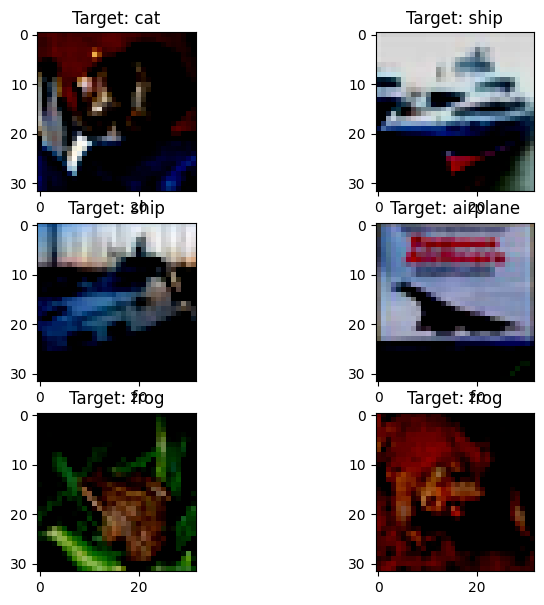

In [4]:
batch_idx, (batch_data, batch_target) = next(enumerate(test_loader))

plt.figure(figsize=(8, 7))
for i in range(6):
    plt.subplot(3, 2, i+1)
    img = batch_data[i]
    img = img.permute((1, 2, 0))
    plt.imshow(img, interpolation='nearest')
    plt.title(f'Target: {class_names[batch_target[i]]}')
plt.show()

#### Define Model and Hyperparameters

In [5]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=2, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=2, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 7 * 7, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = x.reshape((x.shape[0], x.shape[1]*x.shape[2]*x.shape[3]))
        x = self.classifier(x)
        return x

In [6]:
model = Model()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=model.parameters(), lr=0.01)

model

Model(
  (block1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

#### Define Helper Functions

In [7]:
def accuracy_fn(y_pred, y):
    correct = torch.eq(y_pred, y).sum().item()
    return correct * 100. / len(y)

def train_step(model, data_loader, loss_fn, optimizer, accuracy_fn):
    train_loss, train_acc = 0, 0
    model.train()
    for batch_idx, (X, y) in enumerate(data_loader):
        y_logits = model(X)
        y_pred = torch.argmax(torch.sigmoid(y_logits), dim=1)
        loss = loss_fn(y_logits, y)
        acc = accuracy_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += acc
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    return train_loss, train_acc

def test_step(model, data_loader, loss_fn, accuracy_fn):
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            y_logits = model(X)
            y_pred = torch.argmax(torch.sigmoid(y_logits), dim=1)
            loss = loss_fn(y_logits, y)
            acc = accuracy_fn(y_pred, y)
            test_loss += loss.item()
            test_acc += acc
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    return test_loss, test_acc

def eval_mode(model, data_loader, loss_fn, accuracy_fn):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            y_logits = model(X)
            y_pred = torch.argmax(torch.sigmoid(y_logits), dim=1)
            loss += loss_fn(y_logits, y).item()
            acc += accuracy_fn(y_pred, y)

    loss /= len(data_loader)
    acc /= len(data_loader)
    results = {
        'model_name': model.__class__.__name__,
        'model_loss': loss,
        'model_acc': acc
    }
    return results

In [8]:
epochs = 60
train_losses, train_accs, test_losses, test_accs, epoch_count = [], [], [], [], []
for epoch in tqdm(range(epochs), desc='Training'):
    print(f'Epoch: {epoch}--------')
    train_loss, train_acc = train_step(model, train_loader, loss_fn, optimizer, accuracy_fn)
    test_loss, test_acc = test_step(model, test_loader, loss_fn, accuracy_fn)
    print(f'Train loss: {train_loss:.5f} | Train acc: {train_acc:.5f}')
    print(f'Test loss: {test_loss:.5f} | Test acc: {test_acc:.5f}')
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    epoch_count.append(epoch)

results = eval_mode(model, test_loader, loss_fn, accuracy_fn)

Training:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 0--------


Training:   2%|▏         | 1/60 [00:10<10:47, 10.97s/it]

Train loss: 2.28417 | Train acc: 18.29644
Test loss: 2.23022 | Test acc: 25.15924
Epoch: 1--------


Training:   3%|▎         | 2/60 [00:21<10:15, 10.62s/it]

Train loss: 2.04886 | Train acc: 27.81330
Test loss: 1.88554 | Test acc: 32.87221
Epoch: 2--------


Training:   5%|▌         | 3/60 [00:31<10:04, 10.60s/it]

Train loss: 1.80039 | Train acc: 35.47794
Test loss: 1.72042 | Test acc: 38.19666
Epoch: 3--------


Training:   7%|▋         | 4/60 [00:42<09:47, 10.50s/it]

Train loss: 1.65803 | Train acc: 40.55906
Test loss: 1.59010 | Test acc: 42.51592
Epoch: 4--------


Training:   8%|▊         | 5/60 [00:52<09:33, 10.43s/it]

Train loss: 1.56119 | Train acc: 43.91984
Test loss: 1.57427 | Test acc: 43.80971
Epoch: 5--------


Training:  10%|█         | 6/60 [01:02<09:22, 10.42s/it]

Train loss: 1.48528 | Train acc: 46.94693
Test loss: 1.47752 | Test acc: 47.31290
Epoch: 6--------


Training:  12%|█▏        | 7/60 [01:13<09:12, 10.43s/it]

Train loss: 1.42650 | Train acc: 49.00496
Test loss: 1.48232 | Test acc: 46.39729
Epoch: 7--------


Training:  13%|█▎        | 8/60 [01:23<08:59, 10.37s/it]

Train loss: 1.37523 | Train acc: 50.98705
Test loss: 1.38695 | Test acc: 50.88575
Epoch: 8--------


Training:  15%|█▌        | 9/60 [01:33<08:46, 10.33s/it]

Train loss: 1.33221 | Train acc: 52.60350
Test loss: 1.37799 | Test acc: 50.03981
Epoch: 9--------


Training:  17%|█▋        | 10/60 [01:44<08:35, 10.30s/it]

Train loss: 1.29002 | Train acc: 54.14602
Test loss: 1.36108 | Test acc: 51.69188
Epoch: 10--------


Training:  18%|█▊        | 11/60 [01:54<08:24, 10.30s/it]

Train loss: 1.25077 | Train acc: 55.70852
Test loss: 1.32032 | Test acc: 52.95581
Epoch: 11--------


Training:  20%|██        | 12/60 [02:04<08:12, 10.26s/it]

Train loss: 1.21291 | Train acc: 56.86341
Test loss: 1.34052 | Test acc: 51.92078
Epoch: 12--------


Training:  22%|██▏       | 13/60 [02:14<08:01, 10.24s/it]

Train loss: 1.17801 | Train acc: 58.13819
Test loss: 1.24657 | Test acc: 55.84196
Epoch: 13--------


Training:  23%|██▎       | 14/60 [02:24<07:50, 10.22s/it]

Train loss: 1.14064 | Train acc: 59.52286
Test loss: 1.20284 | Test acc: 56.95661
Epoch: 14--------


Training:  25%|██▌       | 15/60 [02:35<07:42, 10.27s/it]

Train loss: 1.10723 | Train acc: 60.83160
Test loss: 1.24813 | Test acc: 55.64291
Epoch: 15--------


Training:  27%|██▋       | 16/60 [02:45<07:31, 10.25s/it]

Train loss: 1.07184 | Train acc: 62.19230
Test loss: 1.13464 | Test acc: 60.03185
Epoch: 16--------


Training:  28%|██▊       | 17/60 [02:55<07:20, 10.25s/it]

Train loss: 1.04247 | Train acc: 63.32121
Test loss: 1.18527 | Test acc: 57.72293
Epoch: 17--------


Training:  30%|███       | 18/60 [03:05<07:09, 10.22s/it]

Train loss: 1.01219 | Train acc: 64.20037
Test loss: 1.11687 | Test acc: 60.27070
Epoch: 18--------


Training:  32%|███▏      | 19/60 [03:16<06:59, 10.23s/it]

Train loss: 0.98196 | Train acc: 65.30131
Test loss: 1.22077 | Test acc: 56.50876
Epoch: 19--------


Training:  33%|███▎      | 20/60 [03:26<06:48, 10.22s/it]

Train loss: 0.95286 | Train acc: 66.34831
Test loss: 1.38344 | Test acc: 52.87619
Epoch: 20--------


Training:  35%|███▌      | 21/60 [03:36<06:38, 10.22s/it]

Train loss: 0.92690 | Train acc: 67.27542
Test loss: 1.08895 | Test acc: 61.39530
Epoch: 21--------


Training:  37%|███▋      | 22/60 [03:46<06:28, 10.21s/it]

Train loss: 0.89638 | Train acc: 68.49624
Test loss: 1.15977 | Test acc: 58.94705
Epoch: 22--------


Training:  38%|███▊      | 23/60 [03:57<06:17, 10.21s/it]

Train loss: 0.86803 | Train acc: 69.27949
Test loss: 1.07944 | Test acc: 62.97771
Epoch: 23--------


Training:  40%|████      | 24/60 [04:07<06:07, 10.21s/it]

Train loss: 0.84414 | Train acc: 70.39842
Test loss: 1.20394 | Test acc: 58.76791
Epoch: 24--------


Training:  42%|████▏     | 25/60 [04:17<05:57, 10.20s/it]

Train loss: 0.81364 | Train acc: 71.17168
Test loss: 1.10257 | Test acc: 62.55971
Epoch: 25--------


Training:  43%|████▎     | 26/60 [04:27<05:46, 10.20s/it]

Train loss: 0.78811 | Train acc: 72.35254
Test loss: 1.10837 | Test acc: 62.43033
Epoch: 26--------


Training:  45%|████▌     | 27/60 [04:37<05:36, 10.19s/it]

Train loss: 0.76429 | Train acc: 73.24568
Test loss: 1.19490 | Test acc: 59.98209
Epoch: 27--------


Training:  47%|████▋     | 28/60 [04:47<05:26, 10.19s/it]

Train loss: 0.73809 | Train acc: 74.03093
Test loss: 1.14279 | Test acc: 62.27110
Epoch: 28--------


Training:  48%|████▊     | 29/60 [04:58<05:16, 10.20s/it]

Train loss: 0.71281 | Train acc: 74.86013
Test loss: 1.10056 | Test acc: 62.86823
Epoch: 29--------


Training:  50%|█████     | 30/60 [05:08<05:05, 10.19s/it]

Train loss: 0.68519 | Train acc: 75.90913
Test loss: 1.28457 | Test acc: 59.13615
Epoch: 30--------


Training:  52%|█████▏    | 31/60 [05:18<04:55, 10.19s/it]

Train loss: 0.66019 | Train acc: 76.76031
Test loss: 1.17167 | Test acc: 62.06210
Epoch: 31--------


Training:  53%|█████▎    | 32/60 [05:28<04:45, 10.18s/it]

Train loss: 0.63569 | Train acc: 77.65345
Test loss: 1.15070 | Test acc: 63.19666
Epoch: 32--------


Training:  55%|█████▌    | 33/60 [05:38<04:35, 10.20s/it]

Train loss: 0.60945 | Train acc: 78.74441
Test loss: 1.14990 | Test acc: 63.62460
Epoch: 33--------


Training:  57%|█████▋    | 34/60 [05:49<04:25, 10.21s/it]

Train loss: 0.58447 | Train acc: 79.38779
Test loss: 1.26837 | Test acc: 61.87301
Epoch: 34--------


Training:  58%|█████▊    | 35/60 [05:59<04:14, 10.19s/it]

Train loss: 0.55949 | Train acc: 80.51071
Test loss: 1.11939 | Test acc: 64.29140
Epoch: 35--------


Training:  60%|██████    | 36/60 [06:09<04:04, 10.17s/it]

Train loss: 0.53698 | Train acc: 81.21204
Test loss: 1.15119 | Test acc: 63.47532
Epoch: 36--------


Training:  62%|██████▏   | 37/60 [06:19<03:54, 10.18s/it]

Train loss: 0.51443 | Train acc: 82.21907
Test loss: 1.19757 | Test acc: 63.86346
Epoch: 37--------


Training:  63%|██████▎   | 38/60 [06:29<03:44, 10.19s/it]

Train loss: 0.48975 | Train acc: 82.81050
Test loss: 1.23332 | Test acc: 63.19666
Epoch: 38--------


Training:  65%|██████▌   | 39/60 [06:40<03:33, 10.18s/it]

Train loss: 0.46591 | Train acc: 83.71963
Test loss: 1.42276 | Test acc: 60.74841
Epoch: 39--------


Training:  67%|██████▋   | 40/60 [06:50<03:23, 10.20s/it]

Train loss: 0.44321 | Train acc: 84.57880
Test loss: 1.33396 | Test acc: 62.36067
Epoch: 40--------


Training:  68%|██████▊   | 41/60 [07:00<03:13, 10.20s/it]

Train loss: 0.41762 | Train acc: 85.42599
Test loss: 1.30824 | Test acc: 63.66441
Epoch: 41--------


Training:  70%|███████   | 42/60 [07:10<03:03, 10.20s/it]

Train loss: 0.39677 | Train acc: 86.17727
Test loss: 1.33695 | Test acc: 63.66441
Epoch: 42--------


Training:  72%|███████▏  | 43/60 [07:20<02:53, 10.18s/it]

Train loss: 0.36901 | Train acc: 87.20628
Test loss: 1.41991 | Test acc: 62.37062
Epoch: 43--------


Training:  73%|███████▎  | 44/60 [07:30<02:42, 10.17s/it]

Train loss: 0.35119 | Train acc: 87.76574
Test loss: 1.44603 | Test acc: 63.13694
Epoch: 44--------


Training:  75%|███████▌  | 45/60 [07:41<02:32, 10.19s/it]

Train loss: 0.32802 | Train acc: 88.60494
Test loss: 1.58259 | Test acc: 61.00717
Epoch: 45--------


Training:  77%|███████▋  | 46/60 [07:51<02:22, 10.19s/it]

Train loss: 0.31294 | Train acc: 89.08648
Test loss: 1.40325 | Test acc: 64.28145
Epoch: 46--------


Training:  78%|███████▊  | 47/60 [08:01<02:12, 10.19s/it]

Train loss: 0.29036 | Train acc: 89.92767
Test loss: 1.39829 | Test acc: 65.11744
Epoch: 47--------


Training:  80%|████████  | 48/60 [08:12<02:03, 10.27s/it]

Train loss: 0.27312 | Train acc: 90.35326
Test loss: 1.56314 | Test acc: 62.89809
Epoch: 48--------


Training:  82%|████████▏ | 49/60 [08:22<01:53, 10.34s/it]

Train loss: 0.24918 | Train acc: 91.20045
Test loss: 2.46979 | Test acc: 55.40406
Epoch: 49--------


Training:  83%|████████▎ | 50/60 [08:33<01:43, 10.38s/it]

Train loss: 0.23073 | Train acc: 91.88779
Test loss: 1.64671 | Test acc: 63.21656
Epoch: 50--------


Training:  85%|████████▌ | 51/60 [08:43<01:32, 10.32s/it]

Train loss: 0.21691 | Train acc: 92.28141
Test loss: 1.64799 | Test acc: 63.43551
Epoch: 51--------


Training:  87%|████████▋ | 52/60 [08:53<01:22, 10.30s/it]

Train loss: 0.19511 | Train acc: 92.82689
Test loss: 1.86430 | Test acc: 61.39530
Epoch: 52--------


Training:  88%|████████▊ | 53/60 [09:03<01:12, 10.30s/it]

Train loss: 0.18823 | Train acc: 92.84887
Test loss: 1.87208 | Test acc: 61.66401
Epoch: 53--------


Training:  90%|█████████ | 54/60 [09:14<01:01, 10.29s/it]

Train loss: 0.16502 | Train acc: 93.47027
Test loss: 2.00682 | Test acc: 59.77309
Epoch: 54--------


Training:  92%|█████████▏| 55/60 [09:24<00:51, 10.30s/it]

Train loss: 0.15512 | Train acc: 93.60814
Test loss: 2.17607 | Test acc: 59.57404
Epoch: 55--------


Training:  93%|█████████▎| 56/60 [09:34<00:41, 10.30s/it]

Train loss: 0.13796 | Train acc: 93.74600
Test loss: 2.69799 | Test acc: 54.41879
Epoch: 56--------


Training:  95%|█████████▌| 57/60 [09:44<00:30, 10.28s/it]

Train loss: 0.13276 | Train acc: 93.71603
Test loss: 1.91651 | Test acc: 62.66919
Epoch: 57--------


Training:  97%|█████████▋| 58/60 [09:55<00:20, 10.27s/it]

Train loss: 0.10718 | Train acc: 94.21355
Test loss: 2.12368 | Test acc: 60.96736
Epoch: 58--------


Training:  98%|█████████▊| 59/60 [10:05<00:10, 10.24s/it]

Train loss: 0.09477 | Train acc: 94.14762
Test loss: 2.11898 | Test acc: 62.11186
Epoch: 59--------


Training: 100%|██████████| 60/60 [10:15<00:00, 10.26s/it]

Train loss: 0.10703 | Train acc: 93.30842
Test loss: 2.06589 | Test acc: 61.70382


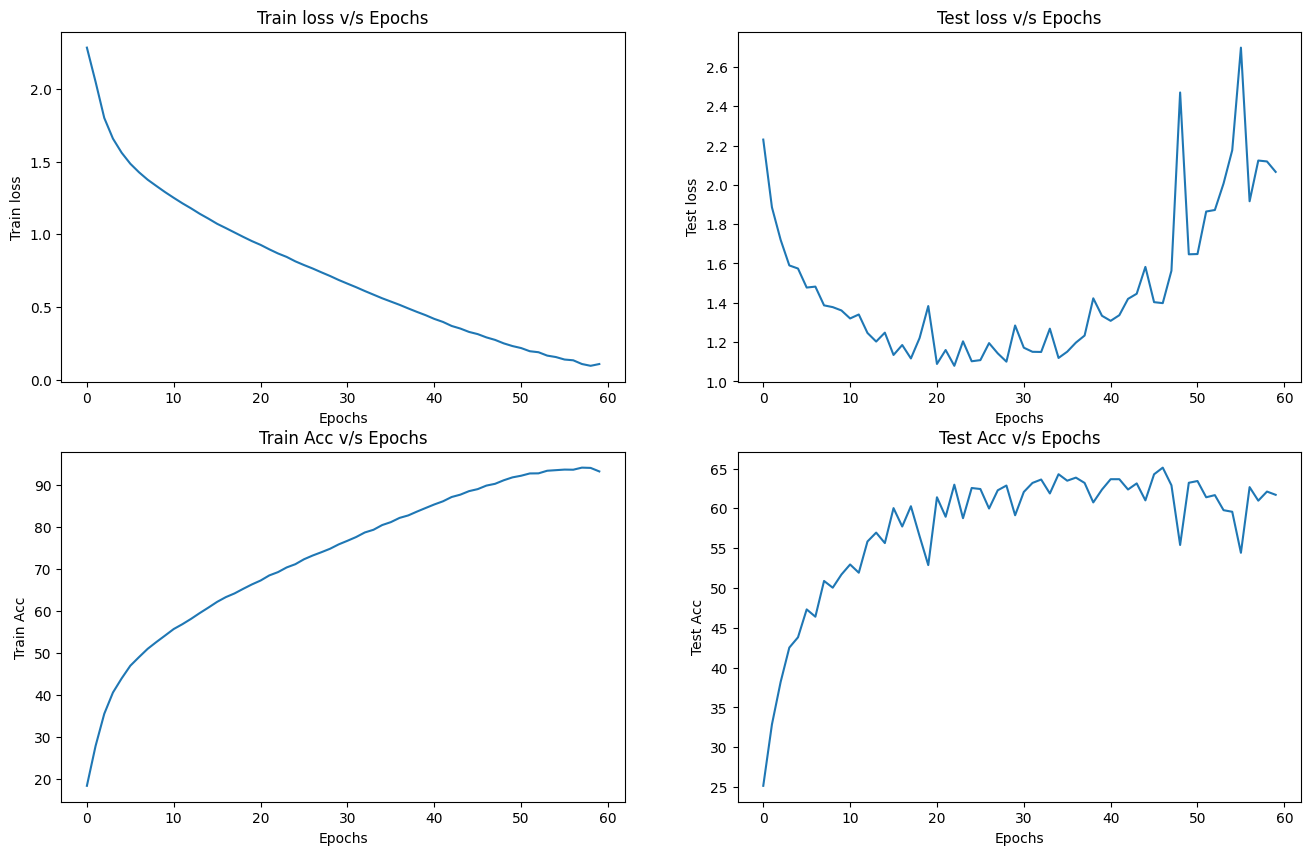

In [9]:
#### Plot loss and accuracy curves
epoch_counts = [i for i in range(epochs)]

plt.figure(figsize=(16, 10))
# Train loss curve
plt.subplot(2, 2, 1)
plt.plot(epoch_counts, train_losses)
plt.xlabel('Epochs')
plt.ylabel('Train loss')
plt.title('Train loss v/s Epochs')

# Test loss curve
plt.subplot(2, 2, 2)
plt.plot(epoch_counts, test_losses)
plt.xlabel('Epochs')
plt.ylabel('Test loss')
plt.title('Test loss v/s Epochs')

# Train acc curve
plt.subplot(2, 2, 3)
plt.plot(epoch_counts, train_accs)
plt.xlabel('Epochs')
plt.ylabel('Train Acc')
plt.title('Train Acc v/s Epochs')

# Test acc curve
plt.subplot(2, 2, 4)
plt.plot(epoch_counts, test_accs)
plt.xlabel('Epochs')
plt.ylabel('Test Acc')
plt.title('Test Acc v/s Epochs')
plt.show()

#### Make predictions

In [10]:
#### Make predictions

batch_idx, (batch_data, batch_targets) = next(enumerate(test_loader))
model.eval()
with torch.inference_mode():
    outputs = model(batch_data)
    predictions = torch.argmax(torch.sigmoid(outputs), dim=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


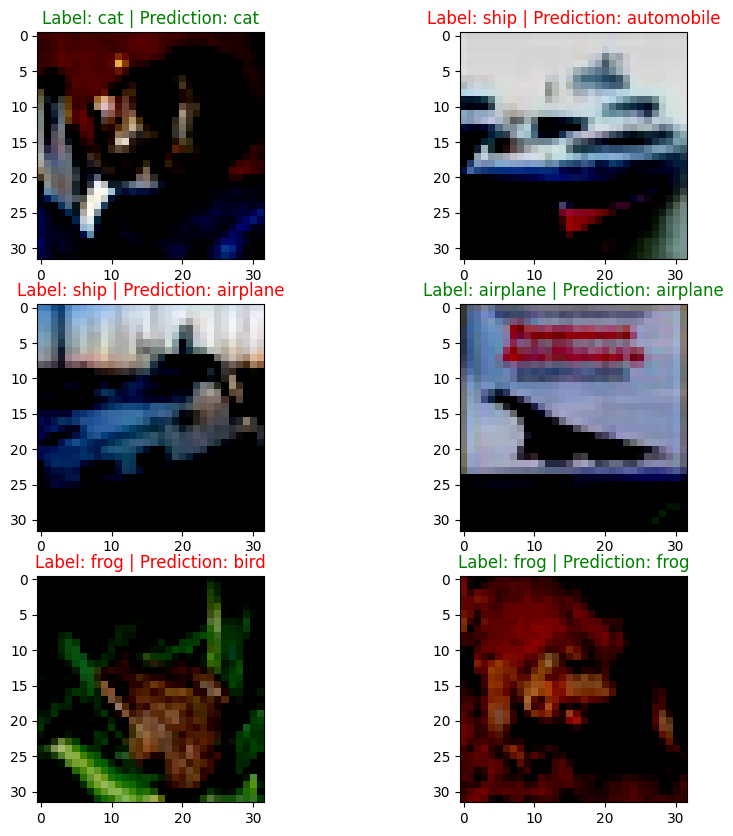

In [11]:
plt.figure(figsize=(10, 10))
for i in range(6):
    plt.subplot(3, 2, i+1)
    img = batch_data[i]
    img = img.permute((1, 2, 0))
    plt.imshow(img, interpolation='nearest')
    label = batch_targets[i]
    prediction = predictions[i]
    if label == prediction:
        plt.title(f'Label: {class_names[label]} | Prediction: {class_names[prediction]}', color = 'green')
    else:
        plt.title(f'Label: {class_names[label]} | Prediction: {class_names[prediction]}', color = 'red')
plt.show()